In [33]:
# import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer 
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import os 
import warnings
warnings.filterwarnings('ignore')

In [128]:
# Extracting Data from a Single Excel File Containing Multiple Stock Index Information
def data_cleaning(original_file_name, saved_file_name):
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'unfinish data')
    original_file = pd.read_excel(os.path.join(index_data_dir, original_file_name))

    # Secid: [RUT:102434 DJX: 102456 SPX: 108105]
    filtered_data = original_file[original_file['Security ID'] == 102434]
    filtered_data['The Date of this Option Price'] = filtered_data['The Date of this Option Price'].dt.strftime('%-d/%-m/%Y')

    # Define the path for the new Excel file
    output_excel_path = os.path.join(index_data_dir, saved_file_name)

    # Write the filtered data to a new Excel file
    filtered_data.to_excel(output_excel_path, index=False)


In [129]:
#data_cleaning('OptionMetrics - Standardized Options.xlsx', 'OptionMetrics - RUT Standardized Options.xlsx')



In [130]:
def data_clearning_for_option(original_file_name, saved_file_name):
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data', 'unfinish data')
    original_file = pd.read_excel(os.path.join(index_data_dir, original_file_name))
    
    # C=Call, P=Put ID
    filtered_data = original_file[original_file['C=Call, P=Put'] == 'P']

    # Define the path for the new Excel file
    output_excel_path = os.path.join(index_data_dir, saved_file_name)
    
    # Write the filtered data to a new Excel file
    filtered_data.to_excel(output_excel_path, index=False)

In [131]:
#data_clearning_for_option('OptionMetrics - RUT Standardized Options.xlsx', 'OptionMetrics - RUT Standardized Options (PUT).xlsx')



In [11]:
# Avoid data leakage to test data
# Impute missing data in train and test datasets using KNNImputer.
def impute_data(train, test):
    imputer = KNNImputer(n_neighbors=5)

    # Fit the imputer on the training data
    imputer.fit(train)

    # Transform both training and testing data
    train_imputed = imputer.transform(train)
    test_imputed = imputer.transform(test)

    return train_imputed, test_imputed

# get the feature data from data folder
def load_feature_data(start_date, test_start_dates, end_date, rebal_period):
    # Load index data, impute missing values and return train and test datasets
    index_data_dir = os.path.join(os.getcwd(), 'data', 'feature_data')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CBOE DJIA Volatility Index':'CBOE DJIA Volatility Index - Close.xlsx',
        'CBOE NASDAQ Volatility Index': 'CBOE NASDAQ Volatility Index - Close.xlsx',
        'CBOE S&P100 Volatility Index': 'CBOE S&P100 Volatility Index - Close.xlsx',
        'CBOE S&P500 Volatility Index': 'CBOE S&P500 Volatility Index - Close.xlsx',
        'OptionMetrics - DJI Historical Volatility': 'OptionMetrics - DJI Historical Volatility.xlsx',
        'OptionMetrics - Russell 2000 Historical Volatility': 'OptionMetrics - Russell 2000 Historical Volatility.xlsx',
        'OptionMetrics - SPX Historical Volatility': 'OptionMetrics - SPX Historical Volatility.xlsx',
        'OptionMetrics - DJX  Index Dividend Yield': 'OptionMetrics - DJX  Index Dividend Yield.xlsx',
        'OptionMetrics - Russell 2000  Index Dividend Yield': 'OptionMetrics - Russell 2000  Index Dividend Yield.xlsx',
        'OptionMetrics - SPX  Index Dividend Yield': 'OptionMetrics - SPX  Index Dividend Yield.xlsx',
        'OptionMetrics - Russel 2000 The total contract open interest': 'OptionMetrics - Russel 2000 The total contract open interest.xlsx',
        'OptionMetrics - Russel 2000 Option Volume': 'OptionMetrics - Russel 2000 Option Volume.xlsx',
        'OptionMetrics - DJX Option Volume': 'OptionMetrics - DJX Option Volume.xlsx',
        'OptionMetrics - DJX The total contract open interest': 'OptionMetrics - DJX The total contract open interest.xlsx',
        'OptionMetrics - SPX Option Volume': 'OptionMetrics - SPX Option Volume.xlsx',
        'OptionMetrics - SPX The total contract open interest': 'OptionMetrics - SPX The total contract open interest.xlsx',
        'OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (CALL)': 'OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (CALL).xlsx',
        'OptionMetrics - DJX Delta of the Option(CALL)': 'OptionMetrics - DJX Delta of the Option(CALL).xlsx',
        'OptionMetrics - DJX Implied Volatility of the Option(CALL)': 'OptionMetrics - DJX Implied Volatility of the Option(CALL).xlsx',
        'OptionMetrics - DJX Interpolated Premium for the Option(CALL)': 'OptionMetrics - DJX Interpolated Premium for the Option(CALL).xlsx',
        'OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price(CALL)': 'OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price(CALL).xlsx',
        'OptionMetrics - DJX Theta of the Option(CALL)': 'OptionMetrics - DJX Theta of the Option(CALL).xlsx',
        'OptionMetrics - DJX VegaKappa of the Option(CALL)': 'OptionMetrics - DJX VegaKappa of the Option(CALL).xlsx',
        'OptionMetrics - Zero Coupon Yield Curve': 'OptionMetrics - Zero Coupon Yield Curve.xlsx',
        'OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (PUT).xlsx': 'OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (PUT).xlsx',
        'OptionMetrics - DJX Delta of the Option (PUT)': 'OptionMetrics - DJX Delta of the Option (PUT).xlsx',
        'OptionMetrics - DJX Gamma of the Option (PUT)': 'OptionMetrics - DJX Gamma of the Option (PUT).xlsx',
        'OptionMetrics - DJX Interpolated Premium for the Option (PUT)': 'OptionMetrics - DJX Interpolated Premium for the Option (PUT).xlsx',
        'OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price (PUT)': 'OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price (PUT).xlsx',
        'OptionMetrics - DJX Theta of the Option (PUT)': 'OptionMetrics - DJX Theta of the Option (PUT).xlsx',
        'OptionMetrics - DJX VegaKappa of the Option (PUT)': 'OptionMetrics - DJX VegaKappa of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (CALL)': 'OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (CALL).xlsx',
        'OptionMetrics - Russell 2000 Delta of the Option(CALL)': 'OptionMetrics - Russell 2000 Delta of the Option(CALL).xlsx',
        'OptionMetrics - Russell 2000 Gamma of the Option(CALL)': 'OptionMetrics - Russell 2000 Gamma of the Option(CALL).xlsx',
        'OptionMetrics - Russell 2000 Implied Volatility of the Option(CALL)': 'OptionMetrics - Russell 2000 Implied Volatility of the Option(CALL).xlsx',
        'OptionMetrics - Russell 2000 Interpolated Premium for the Option (CALL)': 'OptionMetrics - Russell 2000 Interpolated Premium for the Option (CALL).xlsx',
        'OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (CALL)': 'OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (CALL).xlsx',
        'OptionMetrics - Russell 2000 Theta of the Option(CALL)': 'OptionMetrics - Russell 2000 Theta of the Option(CALL).xlsx',
        'OptionMetrics - Russell 2000 VegaKappa of the Option(CALL)': 'OptionMetrics - Russell 2000 VegaKappa of the Option(CALL).xlsx',
        'OptionMetrics - Russell 2000 VegaKappa of the Option (PUT)': 'OptionMetrics - Russell 2000 VegaKappa of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Theta of the Option (PUT)': 'OptionMetrics - Russell 2000 Theta of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Gamma of the Option (PUT)': 'OptionMetrics - Russell 2000 Gamma of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Delta of the Option (PUT)': 'OptionMetrics - Russell 2000 Delta of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Implied Volatility of the Option (PUT)': 'OptionMetrics - Russell 2000 Implied Volatility of the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Interpolated Premium for the Option (PUT)': 'OptionMetrics - Russell 2000 Interpolated Premium for the Option (PUT).xlsx',
        'OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (PUT)': 'OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (PUT).xlsx',
        'OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (PUT)': 'OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (PUT).xlsx',
        'OptionMetrics - SPX Calculated Price for the Underlying Security on the Exp. Date (CALL)': 'OptionMetrics - SPX Calculated Price for the Underlying Security on the Exp. Date (CALL).xlsx',
        'OptionMetrics - SPX Delta of the Option (CALL)': 'OptionMetrics - SPX Delta of the Option (CALL).xlsx',
        'OptionMetrics - SPX Gamma of the Option (CALL)': 'OptionMetrics - SPX Gamma of the Option (CALL).xlsx',
        'OptionMetrics - SPX Implied Volatility of the Option (CALL)': 'OptionMetrics - SPX Implied Volatility of the Option (CALL).xlsx',
        'OptionMetrics - SPX Interpolated Premium for the Option (CALL)': 'OptionMetrics - SPX Interpolated Premium for the Option (CALL).xlsx',
        'OptionMetrics - SPX Standardized Options (PUT)': 'OptionMetrics - SPX Standardized Options (PUT).xlsx',
        'OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL)': 'OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL).xlsx',
        'OptionMetrics - SPX Theta of the Option (CALL)': 'OptionMetrics - SPX Theta of the Option (CALL).xlsx',
        'OptionMetrics - SPX VegaKappa of the Option (PUT)': 'OptionMetrics - SPX VegaKappa of the Option (PUT).xlsx'
        
        
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index, dayfirst=True)
            input = input.sort_index(ascending=False)

            # Calculate monthly percentage changes to enhance the stationarity of the data
            # Fill the first with 0
            index_df = input.iloc[:, 0].resample(rebal_period).first().pct_change().fillna(0)

             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]

            # Handle infinite values
            inf_indices_train = np.where(np.isinf(train_data))[0]
            inf_indices_test = np.where(np.isinf(test_data))[0]

            train_data[inf_indices_train] = np.nan
            test_data[inf_indices_test] = np.nan

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue
    
    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df

In [7]:
# Define general parameters
train_start_date = '2007-01-01'
test_start_date = '2017-01-01'
test_end_date = '2022-12-31'
rebal_period = '1M'
train_data, test_data = load_feature_data(train_start_date, test_start_date, test_end_date, rebal_period)

In [134]:
train_data

,CBOE DJIA Volatility Index,CBOE NASDAQ Volatility Index,CBOE S&P100 Volatility Index,CBOE S&P500 Volatility Index,OptionMetrics - DJI Historical Volatility,OptionMetrics - Russell 2000 Historical Volatility,OptionMetrics - SPX Historical Volatility,OptionMetrics - DJX Index Dividend Yield,OptionMetrics - Russell 2000 Index Dividend Yield,OptionMetrics - SPX Index Dividend Yield,...,OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (PUT),OptionMetrics - SPX Calculated Price for the Underlying Security on the Exp. Date (CALL),OptionMetrics - SPX Delta of the Option (CALL),OptionMetrics - SPX Gamma of the Option (CALL),OptionMetrics - SPX Implied Volatility of the Option (CALL),OptionMetrics - SPX Interpolated Premium for the Option (CALL),OptionMetrics - SPX Standardized Options (PUT),"OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL)",OptionMetrics - SPX Theta of the Option (CALL),OptionMetrics - SPX VegaKappa of the Option (PUT)
2007-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2007-02-28,-0.167095,-0.022286,-0.139153,-0.143688,0.021821,-0.293720,0.188468,-0.008659,-0.005260,-0.011017,...,0.026120,0.004750,-0.017057,2.457303,-0.295413,-1.000000,0.004750,-1.000000,0.589300,-0.581718
2007-03-31,0.543210,0.257160,0.627510,0.534433,-0.051363,0.232237,-0.125091,-0.013126,0.006340,-0.008988,...,-0.029785,-0.014205,0.018820,-0.717814,0.469281,0.351317,-0.014205,-0.097412,-0.362070,1.368411
2007-04-30,-0.111333,-0.135286,-0.149291,-0.081542,0.156752,0.034840,0.181939,0.022004,-0.014006,-0.008592,...,0.059898,0.012705,-0.002195,0.103751,-0.021780,-0.090815,0.012705,0.012705,0.076507,-0.070463
2007-05-31,-0.065266,-0.089247,-0.067440,-0.070200,-0.164748,-0.147630,-0.182500,0.040132,-0.002148,0.008846,...,-0.029287,0.029652,-0.013300,1.413656,-0.099677,-1.000000,0.029652,-1.000000,0.845456,-0.533106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-31,-0.119215,-0.137255,-0.198561,-0.157752,-0.554419,-0.517723,-0.563197,0.014065,-0.047467,-0.011428,...,0.048562,0.025472,0.022114,-0.819477,0.243340,4.416297,0.025472,0.025472,-0.742303,3.352218
2016-09-30,0.023089,0.059917,0.108618,0.083601,-0.178702,-0.096423,-0.178832,0.000146,0.031619,-0.034033,...,0.017031,0.000833,0.001865,-0.036640,0.037986,0.038353,0.000833,0.000833,0.071277,0.000351
2016-10-31,0.101167,0.030539,0.090688,0.006677,0.324072,-0.022546,0.123284,-0.009400,0.027582,0.005273,...,0.004633,0.001371,-0.023311,4.505559,-0.212571,-0.814295,0.001371,0.001371,2.804490,-0.763947
2016-11-30,0.293993,0.302648,0.432814,0.367723,-0.198668,0.006180,-0.052027,0.052655,0.006810,-0.025529,...,-0.054441,-0.027324,0.025130,-0.809544,0.365263,4.156389,-0.027324,-0.027324,-0.687484,2.773296


In [135]:
test_data

,CBOE DJIA Volatility Index,CBOE NASDAQ Volatility Index,CBOE S&P100 Volatility Index,CBOE S&P500 Volatility Index,OptionMetrics - DJI Historical Volatility,OptionMetrics - Russell 2000 Historical Volatility,OptionMetrics - SPX Historical Volatility,OptionMetrics - DJX Index Dividend Yield,OptionMetrics - Russell 2000 Index Dividend Yield,OptionMetrics - SPX Index Dividend Yield,...,OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (PUT),OptionMetrics - SPX Calculated Price for the Underlying Security on the Exp. Date (CALL),OptionMetrics - SPX Delta of the Option (CALL),OptionMetrics - SPX Gamma of the Option (CALL),OptionMetrics - SPX Implied Volatility of the Option (CALL),OptionMetrics - SPX Interpolated Premium for the Option (CALL),OptionMetrics - SPX Standardized Options (PUT),"OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL)",OptionMetrics - SPX Theta of the Option (CALL),OptionMetrics - SPX VegaKappa of the Option (PUT)
2017-01-31,-0.039648,-0.065192,-0.160371,-0.086709,0.778252,-0.018951,0.918979,-0.089049,-0.213779,-0.039418,...,0.041520,0.030558,-0.001650,0.224261,-0.207259,-0.183086,0.030558,0.030558,-0.182313,0.030500
2017-02-28,-0.087920,-0.184932,-0.080645,-0.080934,0.274246,0.260418,-0.116217,-0.000650,0.064367,0.041636,...,-0.003326,0.006236,0.018530,-0.808592,0.316172,4.139493,0.006236,0.006236,-0.688400,2.902582
2017-03-31,0.040235,-0.014515,0.078486,0.061812,-0.115065,0.017440,-0.130000,0.012211,0.059837,-0.016176,...,0.038553,0.052221,-0.000711,0.031996,0.030937,-0.027495,0.052221,0.052221,0.252078,-0.056501
2017-04-30,-0.066076,-0.041085,-0.105308,-0.012759,-0.109128,-0.081031,-0.112142,-0.056011,-0.075780,-0.109490,...,-0.028992,-0.014659,-0.002817,0.154095,-0.119196,-0.132177,-0.014659,-0.014659,-0.112253,-0.014702
2017-05-31,-0.110440,-0.013743,-0.126316,-0.183360,0.032761,-0.019720,-0.002112,0.069939,-0.001119,0.020026,...,0.026184,0.012206,0.001191,-0.108260,-0.009446,0.117679,0.012206,0.012206,-0.109334,0.128273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.015541,-0.161074,0.000000,-0.144569,-0.026410,-0.021402,-0.015714,0.028920,-0.132821,-0.079806,...,0.095581,0.079354,-0.005217,0.027314,-0.095409,-0.025483,0.079354,0.079354,0.020315,0.077795
2022-09-30,0.173615,0.122087,0.000000,0.119089,-0.061084,-0.192642,-0.133378,-0.141515,-0.143456,-0.177297,...,-0.029431,-0.042576,-0.036113,3.205318,-0.031159,-0.759430,-0.042576,-0.042576,2.438880,-0.751299
2022-10-31,0.167716,0.102294,0.000000,0.177621,0.510074,0.466429,0.352875,0.031248,0.504315,0.469008,...,-0.069486,-0.072730,0.004113,-0.173516,0.304587,0.209550,-0.072730,-0.072730,0.199016,-0.072913
2022-11-30,-0.065075,-0.100394,0.000000,-0.142525,-0.436695,-0.498772,-0.307846,0.031530,0.192650,0.232336,...,0.086988,0.048297,-0.000344,-0.032299,-0.014353,0.033169,0.048297,0.048297,0.033169,0.048247


In [15]:
# get target index data
def index_cum_data_loading(start_date, test_start_dates, end_date, rebal_period):
    index_data_dir = os.path.join(os.getcwd(), 'data', 'index_data')
    result_train_df = pd.DataFrame()
    result_test_df = pd.DataFrame()
    
    index_data_name_file = {
        'CRSP Daily Stock Market Indexes - Level of the S&P 500 Index':'CRSP Daily Stock Market Indexes - Level of the S&P 500 Index.xlsx'
    }
    
    for ind_name in index_data_name_file.keys():
        try:
            input = pd.read_excel(os.path.join(index_data_dir, index_data_name_file[ind_name]), index_col='Date')
            # Ensure that the index is a DatetimeIndex
            input.index = pd.to_datetime(input.index, dayfirst=True)
            input = input.sort_index(ascending=False)
            
            reb_index = input.iloc[:, 0].resample(rebal_period).first()
            index_df = reb_index / reb_index.iloc[0]
            
             # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]
            
            # Split the data into train and test based on the provided dates
            train_data = index_df.loc[start_date:test_start_dates]
            test_data = index_df.loc[test_start_dates:end_date]

            train_imputed, test_imputed = impute_data(train_data.values.reshape(-1, 1), test_data.values.reshape(-1, 1))

            # Convert back to Series
            train_imputed_series = pd.Series(train_imputed.flatten(), index=train_data.index)
            test_imputed_series = pd.Series(test_imputed.flatten(), index=test_data.index)

            # Rename the series for clarity
            train_imputed_series.rename(ind_name, inplace=True)
            test_imputed_series.rename(ind_name, inplace=True)

            result_train_df = pd.concat([result_train_df, train_imputed_series], axis=1)
            result_test_df = pd.concat([result_test_df, test_imputed_series], axis=1)
            
        except Exception as e:
            print(f"Error processing file: {index_data_name_file[ind_name]}")
            print(str(e))
            continue

    result_train_df.index = pd.to_datetime(result_train_df.index)
    result_test_df.index = pd.to_datetime(result_test_df.index)

    return result_train_df, result_test_df



In [16]:
index_train_data, index_test_data = index_cum_data_loading(train_start_date, test_start_date, test_end_date, rebal_period)

In [17]:
index_train_data

,CRSP Daily Stock Market Indexes - Level of the S&P 500 Index
2007-01-31,1.000000
2007-02-28,1.020712
2007-03-31,0.990520
2007-04-30,1.005612
2007-05-31,1.049202
...,...
2016-08-31,1.532430
2016-09-30,1.532444
2016-10-31,1.525625
2016-11-30,1.490696


In [18]:
index_test_data

,CRSP Daily Stock Market Indexes - Level of the S&P 500 Index
2017-01-31,1.593837
2017-02-28,1.609170
2017-03-31,1.691345
2017-04-30,1.665142
2017-05-31,1.685959
...,...
2022-08-31,2.907405
2022-09-30,2.800261
2022-10-31,2.596661
2022-11-30,2.722081


In [23]:
def plot_target_index(word_index):
    ax = word_index.plot()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.2f}".format(float(x))))
    plt.xlabel('Date')
    plt.ylabel('Cumulative P&L')
    plt.title('Cumulative Profit and Loss')
    plt.show()

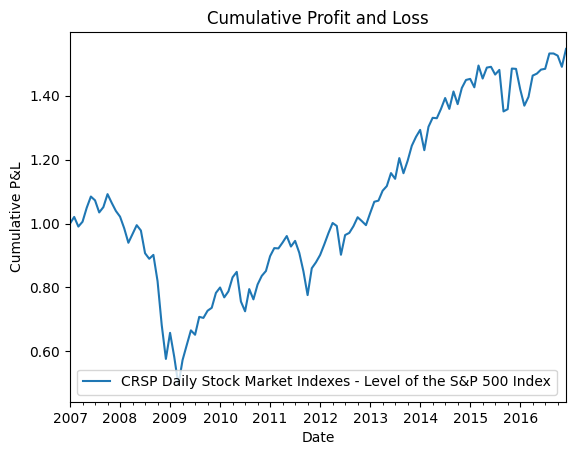

In [24]:
plot_target_index(index_train_data)

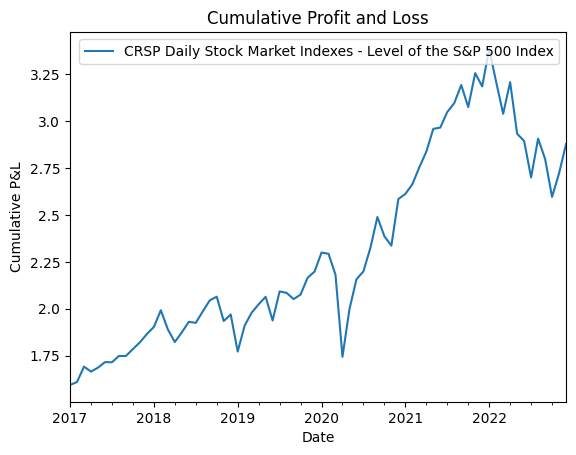

In [22]:
plot_target_index(index_test_data)

In [25]:
train_market_data = train_data.join(index_train_data, how = 'right')
test_market_data = test_data.join(index_test_data, how = 'right')

In [54]:
# Trying different method for feature selection
# Adjust display options to show the full correlation matrix
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
train_market_data.corr()

,CBOE DJIA Volatility Index,CBOE NASDAQ Volatility Index,CBOE S&P100 Volatility Index,CBOE S&P500 Volatility Index,OptionMetrics - DJI Historical Volatility,OptionMetrics - Russell 2000 Historical Volatility,OptionMetrics - SPX Historical Volatility,OptionMetrics - DJX Index Dividend Yield,OptionMetrics - Russell 2000 Index Dividend Yield,OptionMetrics - SPX Index Dividend Yield,OptionMetrics - Russel 2000 The total contract open interest,OptionMetrics - Russel 2000 Option Volume,OptionMetrics - DJX Option Volume,OptionMetrics - DJX The total contract open interest,OptionMetrics - SPX Option Volume,OptionMetrics - SPX The total contract open interest,OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (CALL),OptionMetrics - DJX Delta of the Option(CALL),OptionMetrics - DJX Implied Volatility of the Option(CALL),OptionMetrics - DJX Interpolated Premium for the Option(CALL),"OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price(CALL)",OptionMetrics - DJX Theta of the Option(CALL),OptionMetrics - DJX VegaKappa of the Option(CALL),OptionMetrics - Zero Coupon Yield Curve,OptionMetrics - DJX Calculated Price for the Underlying Security on the Exp. Date (PUT).xlsx,OptionMetrics - DJX Delta of the Option (PUT),OptionMetrics - DJX Gamma of the Option (PUT),OptionMetrics - DJX Interpolated Premium for the Option (PUT),"OptionMetrics - DJX Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - DJX Theta of the Option (PUT),OptionMetrics - DJX VegaKappa of the Option (PUT),OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (CALL),OptionMetrics - Russell 2000 Delta of the Option(CALL),OptionMetrics - Russell 2000 Gamma of the Option(CALL),OptionMetrics - Russell 2000 Implied Volatility of the Option(CALL),OptionMetrics - Russell 2000 Interpolated Premium for the Option (CALL),"OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (CALL)",OptionMetrics - Russell 2000 Theta of the Option(CALL),OptionMetrics - Russell 2000 VegaKappa of the Option(CALL),OptionMetrics - Russell 2000 VegaKappa of the Option (PUT),OptionMetrics - Russell 2000 Theta of the Option (PUT),OptionMetrics - Russell 2000 Gamma of the Option (PUT),OptionMetrics - Russell 2000 Delta of the Option (PUT),OptionMetrics - Russell 2000 Implied Volatility of the Option (PUT),OptionMetrics - Russell 2000 Interpolated Premium for the Option (PUT),"OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (PUT)",OptionMetrics - Russell 2000 Calculated Price for the Underlying Security on the Exp. Date (PUT),OptionMetrics - SPX Calculated Price for the Underlying Security on the Exp. Date (CALL),OptionMetrics - SPX Delta of the Option (CALL),OptionMetrics - SPX Gamma of the Option (CALL),OptionMetrics - SPX Implied Volatility of the Option (CALL),OptionMetrics - SPX Interpolated Premium for the Option (CALL),OptionMetrics - SPX Standardized Options (PUT),"OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL)",OptionMetrics - SPX Theta of the Option (CALL),OptionMetrics - SPX VegaKappa of the Option (PUT),CRSP Daily Stock Market Indexes - Level of the S&P 500 Index
CBOE DJIA Volatility Index,1.000000,0.962420,0.983334,0.986630,0.256359,0.348441,0.218198,-0.022280,-0.129168,-0.126612,0.016530,0.072345,0.082110,0.112053,0.204092,-0.038390,-0.728651,0.199328,0.822205,-0.118027,-0.215462,0.402364,-0.237332,-0.020851,-0.728651,0.034758,-0.003795,-0.113065,-0.215462,0.245784,-0.237393,-0.680427,0.223346,-0.061578,0.778805,-0.035525,-0.098036,0.184718,-0.167811,-0.167846,0.141303,-0.069409,-0.124619,0.820778,-0.030869,-0.098036,-0.680427,-0.726875,0.274722,-0.133090,0.811610,0.052462,-0.726875,-0.082172,0.365138,-0.083562,-0.032132
CBOE NASDAQ Volatility Index,0.962420,1.000000,0.962173,0.970423,0.271833,0.365280,0.244795,-0.019093,-0.152685,-0.113143,0.011622,0.060511,0.090231,0.111456,0.166402,-0.06

In [49]:
# 1. Recursive Feature Elimination (RFE) for Regression
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)
fit = rfe.fit(train_data, index_train_data.values.ravel())
selected_features_rfe = train_data.columns[fit.support_]
print("Num Features:", fit.n_features_)
print("Selected Features:", selected_features_rfe)
print("Feature Ranking:", fit.ranking_)

Num Features: 5
Selected Features: Index(['OptionMetrics - DJX VegaKappa of the Option(CALL)',
       'OptionMetrics - DJX VegaKappa of the Option (PUT)',
       'OptionMetrics - Russell 2000 Delta of the Option(CALL)',
       'OptionMetrics - Russell 2000 VegaKappa of the Option(CALL)',
       'OptionMetrics - Russell 2000 VegaKappa of the Option (PUT)'],
      dtype='object')
Feature Ranking: [ 5  9  4 39 34 50 33 27  7 28 30 44 52 31 46 45 49  3 21 38 47 43  1 35
 48 17 22 37 40 20  1 41  1 14  8 15 16 18  1  1 19 13  2 32 11 29 42 26
  6 51 23 25 12 10 36 24]


In [51]:
# 2. Feature Importance from RandomForest
# If it's regression:
forest = RandomForestRegressor(n_estimators=100)
# If it's classification:
# forest = RandomForestClassifier(n_estimators=100)

forest.fit(train_data, index_train_data.values.ravel())
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(train_data.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, train_data.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. Feature OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL) (0.221596)
2. Feature OptionMetrics - Zero Coupon Yield Curve (0.052923)
3. Feature OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (PUT) (0.047723)
4. Feature OptionMetrics - Russell 2000 Strike Price, Currently Always Equal to Forward Price (CALL) (0.032217)
5. Feature OptionMetrics - DJX Option Volume (0.029566)
6. Feature OptionMetrics - Russel 2000 The total contract open interest (0.026691)
7. Feature OptionMetrics - DJX Implied Volatility of the Option(CALL) (0.024228)
8. Feature OptionMetrics - DJX The total contract open interest (0.022934)
9. Feature OptionMetrics - SPX Delta of the Option (CALL) (0.021920)
10. Feature OptionMetrics - DJX  Index Dividend Yield (0.021339)
11. Feature OptionMetrics - SPX Implied Volatility of the Option (CALL) (0.021222)
12. Feature OptionMetrics - SPX The total contract open interest (0.019748)
13. Fea

In [53]:
# 3. Univariate Selection using SelectKBest
test = SelectKBest(score_func=f_classif, k=5)
fit = test.fit(train_data, index_train_data.values.ravel())
selected_features_skb = train_data.columns[fit.get_support()]
print("Selected Features:", selected_features_skb)

Selected Features: Index(['OptionMetrics - SPX Interpolated Premium for the Option (CALL)',
       'OptionMetrics - SPX Standardized Options (PUT)',
       'OptionMetrics - SPX Strike Price, Currently Always Equal to Forward Price (CALL)',
       'OptionMetrics - SPX Theta of the Option (CALL)',
       'OptionMetrics - SPX VegaKappa of the Option (PUT)'],
      dtype='object')


/Users/raymondli/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:109: RuntimeWarning: invalid value encountered in divide
  msw = sswn / float(dfwn)
